# INTELIGENCIA ARTIFICIAL (1INF24)
Dr. Edwin Villanueva Talavera (ervillanueva@pucp.edu.pe)

##Experimentando con Algoritmos de Inteligencia Colectiva (PSO, ABC)

En este notebook se presenta la implementación de dos algoritmos de Inteligencia Colectiva para minimizar funciones continuas no convexas: el Algoritmo PSO y el Algoritmo ABC.  

Al final de este notebook encontrará las preguntas que serán evaluadas

### Importa librerias que se van a usar

In [4]:
#@title Imports - Ejecutar esta celda
import numpy as np
import time
import math
import random as rand
from operator import attrgetter
from copy import deepcopy
import matplotlib.pyplot as plt

np.random.seed(0)

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## PARTICLE SWARM OPTIMIZATION (PSO)


### Define clase Particle
Un Objeto de esta clase almacena informacion de una particula (solucion candidata) en PSO

In [5]:
class Particle(object):
    """Clase Particle para almacenar informacion de una particula en PSO """

    def __init__(self, initial_position, initial_velocity, fitness): #constructor recibe posicion y velocidad inicial y fitness
        self.position = initial_position
        self.velocity = initial_velocity
        self.fitness = fitness
        self.best_position = initial_position
        self.best_fitness = fitness

### Define clase PSO_particles.
Un Objeto de esta clase almacena información de las partículas creadas para PSO

In [6]:
class PSO_particles:
    """ Clase que implementa el generador de partículas del optimizador PSO. El constructor puede recibir:
        PN: numero de particulas (Particles Number)
        coord_min: vector con los limites inferiores para delimitar el espacio de busqueda
        coord_max: vector con los limites superiores para delimitar el espacio de busqueda """

    def __init__(self, PN, coord_min, coord_max, seed=0):
        self.PN = PN
        self.coord_min = np.array(coord_min)
        self.coord_max = np.array(coord_max)
        self.seed = seed
        self.values = self.initialize_particles()

    def create_particle(self):   # Instancia una particula aleatoria dentro de los limites de busqueda
        num_dimensions = len(self.coord_min)
        position = np.array([self.coord_min[i] + rand.random() * (self.coord_max[i] - self.coord_min[i]) for i in range(num_dimensions)])
        Vmin = -1*(self.coord_max - self.coord_min)
        Vmax = (self.coord_max - self.coord_min)
        velocity = np.array([Vmin[i] + rand.random() * (Vmax[i] - Vmin[i]) for i in range(num_dimensions)])
        return [position, velocity]

    def initialize_particles(self):  # crea las PN particles de PSO
        return [self.create_particle() for _ in range(self.PN)]

### Define clase PSO.
Un Objeto de esta clase instancia un optimizador PSO para un problema dado

In [7]:
class PSO:
    """ Clase que implementa el optimizador PSO. El constructor puede recibir:
        fn: La funcion a ser minimizada
        w: factor de inercia de la particula
        phi1: peso de aprendizaje cognitivo
        phi2: peso de aprendizaje social
        max_iter: número total de iteraciones que ejecutará PSO """

    def __init__(self, fn, particles, w, phi1, phi2, max_iter):
        self.fn = fn
        self.PN = particles.PN
        self.coord_min = particles.coord_min
        self.coord_max = particles.coord_max
        self.w = w
        self.phi1 = phi1
        self.phi2 = phi2
        self.max_iter = max_iter
        self.particles = self.set_particles(particles.values)
        self.best_position_swarm = []
        self.best_fitness_swarm = []

    def set_particles(self, particles):
        return [Particle(solution[0], solution[1], self.fitness(solution[0])) for solution in particles]

    def fitness(self, position):
        # el fitness para fn positivos es trasladado a valores entre [0,1]: 0 para fn=inf y 1 para fn=0.
        # el fitness para fn negativos es trasladado a valores entre ]1,inf]: 1 para fn=-0 y inf para fn=-inf
        result = self.fn(position)
        if result >= 0:
            fitness = 1 / (1 + result)
        else:
            fitness = 1 + abs(result)
        return fitness

    def get_bestparticle(self):
        best = max(self.particles, key=attrgetter('fitness'))
        return best

    def optimize(self):
        start_time = time.time()
        print ('Iniciando optimizacion con Algoritmo PSO')

        history_bestfitness = []
        history_bestsolution = []
        best_particle = self.get_bestparticle()
        self.best_position_swarm, self.best_fitness_swarm = deepcopy(best_particle.position), best_particle.fitness
        history_bestfitness.append(self.best_fitness_swarm)  # almacena la historia de mejores fitness en cada ciclo
        history_bestsolution.append(self.best_position_swarm)
        print("Mejor solucion inicial = {}, fitness = {}".format(self.best_position_swarm, self.best_fitness_swarm))

        for g in range(self.max_iter):  # For each cycle

            for i in range(self.PN): # por cada particula en el swarm

                # si la particula i es mejor que la mejor posicion que ya vió la particula
                if self.particles[i].fitness > self.particles[i].best_fitness:
                    self.particles[i].best_position = deepcopy(self.particles[i].position)
                    self.particles[i].best_fitness =  self.particles[i].fitness

                # si la mejor posicion que ya vió la particula i es mejor que la mejor position de todo el swarm
                if self.particles[i].best_fitness > self.best_fitness_swarm:
                    self.best_position_swarm = deepcopy(self.particles[i].best_position)
                    self.best_fitness_swarm  = self.particles[i].best_fitness

            # Actualiza la velocidad y position de cada particula 1
            for i in range(self.PN): # por cada particula en el swarm
                r1 = rand.random()
                r2 = rand.random()
                self.particles[i].velocity = self.w*self.particles[i].velocity + self.phi1*r1*(self.particles[i].best_position - self.particles[i].position) + self.phi2*r2*(self.best_position_swarm - self.particles[i].position)
                self.particles[i].position = self.particles[i].position + self.particles[i].velocity
                self.particles[i].fitness  = self.fitness(self.particles[i].position)


             ## Obtiene la mejor posicion encontrada en este ciclo
            best_particle = self.get_bestparticle()  # mejor posicion del presente ciclo
            history_bestfitness.append(best_particle.fitness)
            history_bestsolution.append(best_particle.position)

            if (g % 5 == 0): # muestra resultados cada 5 ciclos
                print("Ciclo {}, Mejor solucion del ciclo = {} (fitness = {}))".format(g, best_particle.position, best_particle.fitness ))

        end_time = time.time()
        print("Mejor solucion encontrada por PSO: {}, fitness = {}. Tomo {} seg ".format(self.best_position_swarm, self.best_fitness_swarm, end_time-start_time))
        return self.best_position_swarm, self.best_fitness_swarm, history_bestfitness, history_bestsolution

## ARTIFICIAL BEE COLONY (ABC)

### Define clase FoodSource.
Un Objeto de esta clase almacena informacion de una fuente de comida (solucion candidata) en ABC


In [8]:
class FoodSource(object):
    """Clase FoodSource para almacenar informacion de una fuente de comida en ABC """

    def __init__(self, solution, fitness):  # el constructor recibe una posible solucion (localizacion) y su fitness
        self.solution = solution
        self.fitness = fitness
        self.trials = 0  # esta informacion almacena las veces que la fuente se ha intentado mejorar sin exito

### Define clase ABC_foodsources.
Un Objeto de esta clase almacena información de las fuentes de comida creadas para ABC

In [9]:
class ABC_foodsources:
    """ Clase que implementa el generador de comida del optimizador ABC. El constructor puede recibir:
        SN: numero de fuentes de comida (Source Number)
        coord_min: vector con los limites inferiores para delimitar el espacio de busqueda
        coord_max: vector con los limites superiores para delimitar el espacio de busqueda """

    def __init__(self, SN, coord_min, coord_max, seed=0):
        self.SN = SN
        self.coord_min = np.array(coord_min)
        self.coord_max = np.array(coord_max)
        self.seed = seed
        self.values = self.initialize_foodsources()

    def get_randomsolution(self):  # retorna una solucion generada aleatoriamente dentro de los limites coord_min, coord_max
        r = rand.random()
        return self.coord_min + r*(self.coord_max - self.coord_min)

    def create_foodsource(self):   # Instancia una fuente de comida aleatoria dentro de los limites de busqueda,
        solution = self.get_randomsolution()
        return solution

    def initialize_foodsources(self):  # crea las SN fuentes de comida
        rand.seed(self.seed)
        return [self.create_foodsource() for _ in range(self.SN)]

### Define clase ABC.
Un Objeto de esta clase instancia un optimizador ABC para un problema dado

In [10]:
class ABC:
    """ Clase que implementa el optimizador ABC. El constructor puede recibir:
        fn: La funcion a ser minimizada
        foodsources: Fuentes de comida
        limit: Número de ciclos que será conservada una solución sin mejorar antes de ser reemplazada
        max_iter: Número total de iteraciones que ejecutará ABC """

    def __init__(self, fn, foodsources, limit, max_iter):
        self.fn = fn
        self.SN = foodsources.SN
        self.coord_min = foodsources.coord_min
        self.coord_max = foodsources.coord_max
        self.limit = limit
        self.max_iter = max_iter
        self.foodsources = self.set_foodsources(foodsources.values)
        self.fn_create_foodsource = foodsources.create_foodsource

    def set_foodsources(self, foodsources):
        return [FoodSource(solution, self.fitness(solution)) for solution in foodsources]

    def fitness(self, solution):
        # el fitness para fn positivos es trasladado a valores entre [0,1]: 0 para fn=inf y 1 para fn=0.
        # el fitness para fn negativos es trasladado a valores entre ]1,inf]: 1 para fn=-0 y inf para fn=-inf

        #return -1*self.fn(solution)
        result = self.fn(solution)
        if result >= 0:
            fitness = 1 / (1 + result)
        else:
            fitness = 1 + abs(result)
        return fitness

    def produce_neighboursolution(self, foodsource_index):  # genera una solucion candidata en la vecindad de la fuente foodsource_index
        Xi = self.foodsources[foodsource_index].solution  # solucion de la fuente pasada
        other_source_indexes = list(range(self.SN))
        del(other_source_indexes[foodsource_index]) # remueve la fuente pasada para no ser seleccionada
        k = rand.choice(other_source_indexes)  # escoje aleatoriamente otra fuente para generar una solucion candidata
        Xk = self.foodsources[k].solution  # solucion de la otra fuente
        r = rand.uniform(-1, 1)
        return  Xi + r * (Xi - Xk)

    def get_bestsolution(self, X, V):  # devuelve la solucion con mejor fitness entre la solucion actual X y una solucion candidata V
        if self.fitness(V) > self.fitness(X):
            return V
        else:
            return X

    def get_probs_foodsources(self): # calcula las probabilidades de las fuentes de comida
        fitness_sum = sum([fs.fitness for fs in self.foodsources])
        return [fs.fitness/fitness_sum  for fs in self.foodsources]

    def update_solution_foodsource(self, foodsource, new_solution):  # actualiza la solucion de la fuente de comida
        if np.array_equal(new_solution, foodsource.solution): # si es la misma solucion entonces solo aumenta trials de la fuente
            foodsource.trials += 1
        else: # si la nueva solucion es mejor que la actual de la fuente de comida -> actualiza solucion y fitness
            foodsource.solution = new_solution
            foodsource.fitness = self.fitness(new_solution)
            foodsource.trials = 0

    def selection(self, probabilities):  # selecciona una fuente de comida basada en sus probabilidades
        return rand.choices(range(self.SN), probabilities)[0]

    def get_bestfoodsource(self):
        best = max(self.foodsources, key=attrgetter('fitness'))
        return best

    def create_new_foodsource(self):
        solution = self.fn_create_foodsource()
        return FoodSource(solution, self.fitness(solution))

    def optimize(self):
        start_time = time.time()
        print('Iniciando optimizacion con Algoritmo ABC')

        history_bestfitness = []
        history_bestsolution = []
        best_foodsource = self.get_bestfoodsource()
        best_solution, best_fitness = deepcopy(best_foodsource.solution), best_foodsource.fitness
        history_bestfitness.append(best_fitness)  # almacena la historia de mejores fitness en cada ciclo
        history_bestsolution.append(best_solution)
        print("Mejor solucion inicial = {}, fitness = {}".format(best_solution, best_fitness))

        for g in range(self.max_iter):  # For each cycle

            ## Etapa de Abejas empleadas (Employed bee)
            for i in range(self.SN): # por cada abeja empleada
                foodsource = self.foodsources[i]
                Vi = self.produce_neighboursolution(i)  # produce una solucion en la vecindad de foodsource
                solution = self.get_bestsolution(foodsource.solution, Vi) # selecciona la mejor solucion entre la actual y la candidata
                self.update_solution_foodsource(foodsource, solution) # actualiza la solucion en la fuente escogida

            ## Etapa de Abejas Observadoras (Onlooker bee)
            for i in range(self.SN): # por cada abeja observadora
                probabilities = self.get_probs_foodsources()   # calcula las probabilidades de todas las fuentes de comida
                index_foodsource = self.selection(probabilities) # selecciona una fuente de comida en base a las probabilidades (metodo ruleta)
                foodsource = self.foodsources[index_foodsource]
                Vi = self.produce_neighboursolution(index_foodsource)  # produce una solucion en la vecindad de selected_foodsource
                solution = self.get_bestsolution(foodsource.solution, Vi) # selecciona la mejor solucion entre la fuente seleccionada actual y la candidata
                self.update_solution_foodsource(foodsource, solution)  # actualiza la solucion en la fuente escogida

            ## Etapa de Abejas exploradoras (Scout bee)
            for i in range(self.SN): # por cada fuente de comida
                foodsource = self.foodsources[i]
                if foodsource.trials > self.limit:  # si el numero de veces que se intento mejorar la fuente excede el limite entonces abandona
                    self.foodsources[i] = self.create_new_foodsource() # reemplaza la fuente de comida i  por una nueva

            ## Memoriza la mejor solucion alcanzada hasta ahora
            best_foodsource = self.get_bestfoodsource()  # mejor fuente del presente ciclo
            history_bestfitness.append ( best_foodsource.fitness )
            history_bestsolution.append(best_foodsource.solution)
            if best_foodsource.fitness >  best_fitness:  # si la mejor solucion del ciclo es mejor que la mejor solucion histórica
                best_solution, best_fitness = deepcopy(best_foodsource.solution), best_foodsource.fitness

            if (g % 5 == 0): # muestra resultados cada 5 ciclos
                print("Ciclo {}, Mejor solucion del ciclo = {} (fitness = {}))".format(g, best_foodsource.solution, best_foodsource.fitness))

        end_time = time.time()
        print("Mejor solucion encontrada por ABC: {}, fitness = {}. Tomo {} seg ".format(best_solution, best_fitness, end_time-start_time))
        return best_solution, best_fitness, history_bestfitness, history_bestsolution

 ## Funciones benchmark para evaluar el algoritmo ABC y PSO

Define 3 funciones benchmark para probar el algoritmo ABC para encontrar sus minimos globales. El fitness del optimo global en todos los casos es = 0


In [11]:
## Funcion  ackley, Typical coord_min = [-20, -20] , coord_max = [20, 20] , optimum at  [0, 0]
def ackley(d, *, a=20, b=0.2, c=2*np.pi):
    sum_part1 = np.sum([x**2 for x in d])
    part1 = -1.0 * a * np.exp(-1.0 * b * np.sqrt((1.0/len(d)) * sum_part1))
    sum_part2 = np.sum([np.cos(c * x) for x in d])
    part2 = -1.0 * np.exp((1.0 / len(d)) * sum_part2)

    return a + np.exp(1) + part1 + part2

## Funcion  rastrigin, Typical coord_min = [-5, -5] , coord_max = [5, 5] , optimum at  [0, 0]
def rastrigin(d):
    sum_i = np.sum([x**2 - 10*np.cos(2 * np.pi * x) for x in d])
    return 10 * len(d) + sum_i

## Funcion  rosenbrock,  Typical  coord_min = [-3, -3] , coord_max = [3, 3] , optimum at  [0, 0]
def rosenbrock(d, a=1, b=100):
    return (a - d[0])**2 + b * (d[1] - d[0]**2)**2

## Funcion  schwefel, Typical coord_min = [-500, -500] , coord_max = [500, 500] , optimum at [420.968, 420.968]
def schwefel(x):
    val = 0
    d = len(x)
    for i in range(d):
        val += x[i] * math.sin(math.sqrt(abs(x[i])))
    val = 418.9829 * d - val
    return val

 ## Probando el algoritmo PSO

 los parametros que se pasan a PSO son (fn, PN, Xmin, Xmax, w, phi1, phi2, max_iter):

        fn: La funcion a ser minimizada
        PN: numero de particulas
        Xmin: vector con los limites inferiores para delimitar el espacio de busqueda
        Xmax: vector con los limites superiores para delimitar el espacio de busqueda
        w: factor de inercia de la particula
        phi1: peso de aprendizaje cognitivo
        phi2: peso de aprendizaje social
        max_iter: número total de iteraciones que ejecutará PSO

In [24]:
# instancia poblacion de particulas para PSO
coord_min = [-20, -20, -20, -20, -20, -20, -20, -20, -20, -20, -20, -20, -20, -20, -20, -20]
coord_max = [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20 ]

initial_particles = PSO_particles(100, coord_min, coord_max)

Iniciando optimizacion con Algoritmo PSO
Mejor solucion inicial = [  2.43471029   3.55340237   4.85746142 -11.3374859   -6.40905844
  11.47312562  -1.35895787  -2.86393858   8.39327811  -0.84521445
  -4.85136513   9.71282852   3.81053823  -7.12889992   2.26865505
  10.91617401], fitness = 0.05667577581110065
Ciclo 0, Mejor solucion del ciclo = [ 2.63480569 -5.20942808 -7.89517564 -0.70487473  9.08301053 13.13618824
  6.06148067 -2.40096124  8.22045736  1.69686201  4.25482843 -3.26821891
  5.56146708  7.78756481 11.59398018  3.92043249] (fitness = 0.05710699008333496))
Ciclo 5, Mejor solucion del ciclo = [ 3.39708016 -1.0128636   0.28236955  0.76397045  3.01615275  3.94977807
  0.40936189  0.92053631  1.05490918  1.79705873  1.70298873  4.86051823
  1.82090282  1.96471083  1.96471742 -0.66635626] (fitness = 0.10456601293938746))
Ciclo 10, Mejor solucion del ciclo = [ 0.51198749 -0.09078241 -0.49524463 -0.84834982  0.9022237   1.95879589
  2.01966372 -0.03889247 -0.07989803  0.29829684  

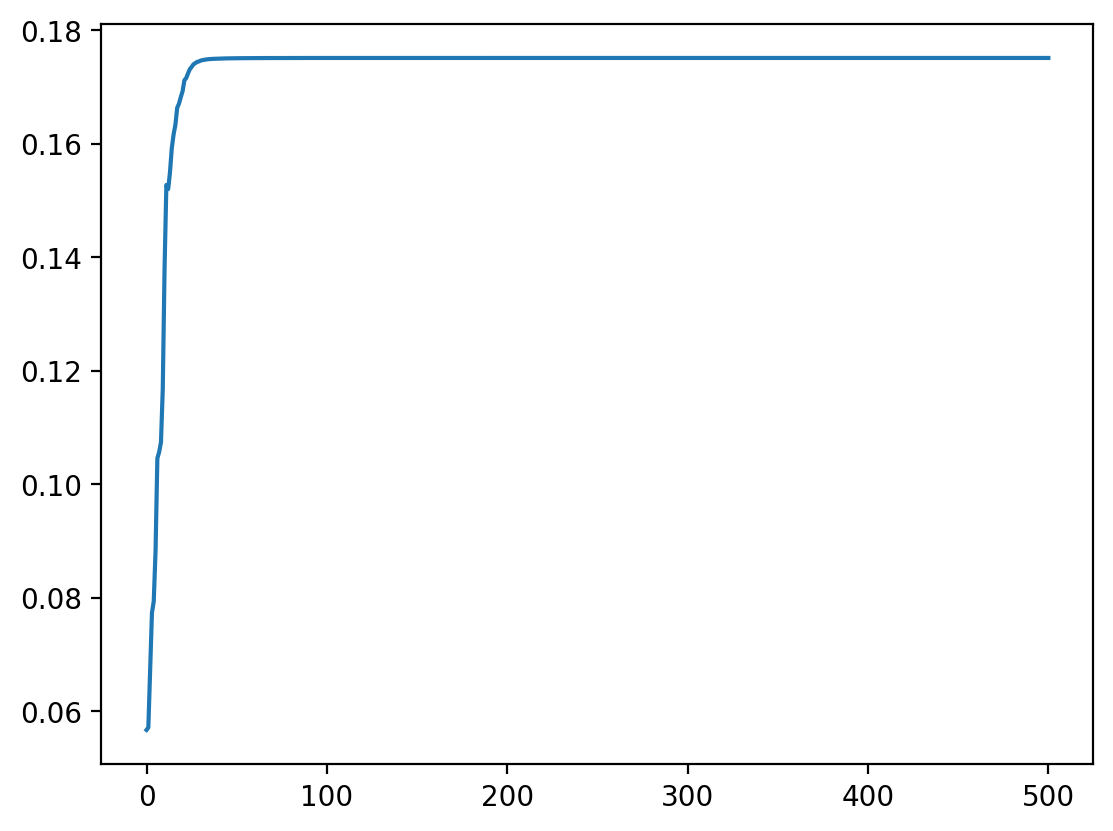

Minimo encontrado con PSO en funcion Ackley: [ 0.89948986 -0.01314791  0.02473581 -0.85653963  0.93408333  1.92072262
  1.86577128  0.12791904 -1.00720127  0.00819794  1.98608221  0.99267158
  0.01375353  2.81707782 -0.96477728  0.03194363], fn=4.7096486257627745


In [25]:
# instancia optimizador PSO para minimizar la funcion ackley
pso_optimizer_ackley = PSO(ackley, initial_particles, 0.4, 1, 1, 500)   # w= .01,  phi1=1, phi2=1, iterations=50
best_solution, best_fitness, history_bestfitness, history_bestsolution = pso_optimizer_ackley.optimize()

# muestra la evolucion del mejor fitness
plt.plot(history_bestfitness)
plt.show()

ackley_best_solution = ackley(best_solution)
print("Minimo encontrado con PSO en funcion Ackley: {}, fn={}".format(best_solution, ackley_best_solution))

 ## Probando el algoritmo ABC

 los parametros que se pasan a ABC son (fn, SN, Xmin, Xmax, limit, max_iter):

        fn: La funcion a ser minimizada
        SN: numero de fuentes de comida (Source Number)
        Xmin: vector con los limites inferiores para delimitar el espacio de busqueda
        Xmax: vector con los limites superiores para delimitar el espacio de busqueda
        limit: numero de ciclos que será conservada una solución sin mejorar antes de ser reemplazada
        max_iter: número total de iteraciones que ejecutará ABC

In [28]:
# instancia fuentes de comida para ABC
coord_min = [-20, -20, -20, -20, -20, -20, -20, -20, -20, -20, -20, -20, -20, -20, -20, -20]
coord_max = [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20 ]

initial_foodsources = ABC_foodsources(5, coord_min, coord_max) # 5 fuentes

Iniciando optimizacion con Algoritmo ABC
Mejor solucion inicial = [0.45098885 0.45098885 0.45098885 0.45098885 0.45098885 0.45098885
 0.45098885 0.45098885 0.45098885 0.45098885 0.45098885 0.45098885
 0.45098885 0.45098885 0.45098885 0.45098885], fitness = 0.19771934460324359
Ciclo 0, Mejor solucion del ciclo = [0.30892802 0.30892802 0.30892802 0.30892802 0.30892802 0.30892802
 0.30892802 0.30892802 0.30892802 0.30892802 0.30892802 0.30892802
 0.30892802 0.30892802 0.30892802 0.30892802] (fitness = 0.2369550697304413))
Ciclo 5, Mejor solucion del ciclo = [0.04415723 0.04415723 0.04415723 0.04415723 0.04415723 0.04415723
 0.04415723 0.04415723 0.04415723 0.04415723 0.04415723 0.04415723
 0.04415723 0.04415723 0.04415723 0.04415723] (fitness = 0.7825691240364014))
Ciclo 10, Mejor solucion del ciclo = [-0.00731063 -0.00731063 -0.00731063 -0.00731063 -0.00731063 -0.00731063
 -0.00731063 -0.00731063 -0.00731063 -0.00731063 -0.00731063 -0.00731063
 -0.00731063 -0.00731063 -0.00731063 -0.0073

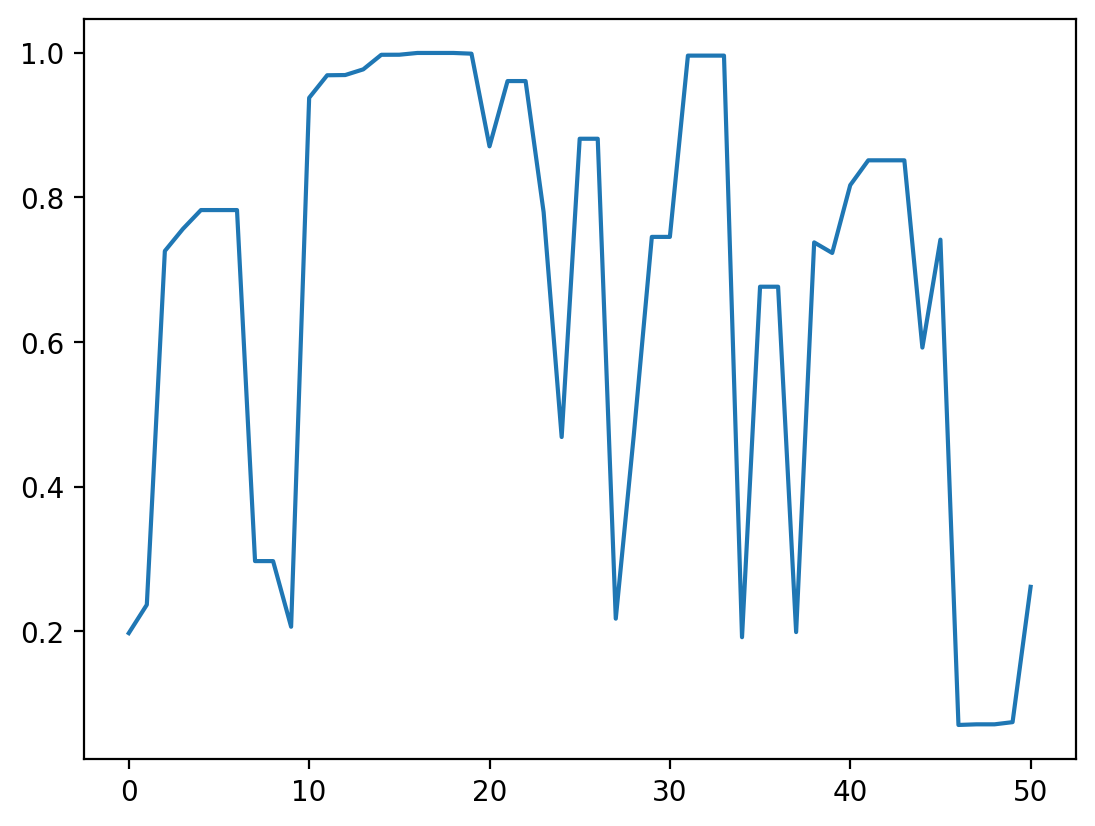

Minimo encontrado con ABC en funcion Ackley: [-6.03218913e-05 -6.03218913e-05 -6.03218913e-05 -6.03218913e-05
 -6.03218913e-05 -6.03218913e-05 -6.03218913e-05 -6.03218913e-05
 -6.03218913e-05 -6.03218913e-05 -6.03218913e-05 -6.03218913e-05
 -6.03218913e-05 -6.03218913e-05 -6.03218913e-05 -6.03218913e-05], fn=0.0002414813519040493


In [29]:
# instancia optimizador ABC para minimizar la funcion ackley
abc_optimizer_ackley = ABC(ackley, initial_foodsources, 5, 50)  #limit=25, iterations=50
best_solution, best_fitness, history_bestfitness, history_bestsolution = abc_optimizer_ackley.optimize()

# muestra la evolucion del mejor fitness
plt.plot(history_bestfitness)
plt.show()

ackley_best_solution = ackley(best_solution)
print("Minimo encontrado con ABC en funcion Ackley: {}, fn={}".format(best_solution, ackley_best_solution))
